## Imports

In [ ]:
import torch
import numpy as np
import pandas as pd
import albumentations as A
import cv2
import os

from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torchvision import  models
from xml.dom import minidom
from matplotlib import pyplot as plt

## Dataset

In [43]:
def extract_xml_data(images_dir ,annot_file):
    xml_file = minidom.parse(annot_file)

    xmin = xml_file.getElementsByTagName('xmin')
    x1 = float(xmin[0].firstChild.data) 

    ymin = xml_file.getElementsByTagName('ymin')
    y1 = float(ymin[0].firstChild.data) 

    xmax = xml_file.getElementsByTagName('xmax')
    x2 = float(xmax[0].firstChild.data)

    ymax = xml_file.getElementsByTagName('ymax')
    y2 = float(ymax[0].firstChild.data) 

    class_name = xml_file.getElementsByTagName('name')

    if class_name[0].firstChild.data == "cat":
        class_num = 0
    else:
        class_num = 1

    image_file = xml_file.getElementsByTagName('filename')
    image_name = image_file[0].firstChild.data

    image_path = os.path.join(images_dir, image_name)
    
    

    return image_name, class_num, x1 , y1 , x2 , y2 



In [44]:
def xml_to_csv():
    annots_list = []

    images_dir = 'dataset/images/'
    annots_dir = 'dataset/annot/'

    xml_files_name = os.listdir(annots_dir)

    for xml_name in xml_files_name:
        xml_path = os.path.join(annots_dir, xml_name)
        annot = extract_xml_data(images_dir ,xml_path)

        annots_list.append(annot)
    
    annots_columns = ['image_name', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
    annots_df = pd.DataFrame(annots_list, columns=annots_columns)

    return annots_df


In [45]:
labels_annots = xml_to_csv()
labels_annots

,image_name,label,xmin,ymin,xmax,ymax
0,cat.0.jpg,0,55.358205,10.992091,197.387579,171.245211
1,cat.1.jpg,0,49.572895,24.298304,256.000000,256.000000
2,cat.10.jpg,0,10.232775,26.033898,256.000000,256.000000
3,cat.100.jpg,0,29.035035,10.413560,233.545772,256.000000
4,cat.101.jpg,0,16.885880,10.702824,256.000000,256.000000
...,...,...,...,...,...,...
1195,dog.9076.jpg,1,43.859883,29.649718,135.954802,86.851982
1196,dog.9077.jpg,1,64.903955,20.827121,200.677966,256.000000
1197,dog.9078.jpg,1,66.061021,20.537854,199.123168,235.462151
1198,dog.9079.jpg,1,3.290398,4.338983,256.000000,244.790960


In [46]:
labels_annots.to_csv('./dataset/label_annot_dataset.csv', index=False)

In [47]:
train_transform = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.RandomCrop(width=224, height=224),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.OneOf(
            [
                A.Blur(blur_limit=3, p=0.5),
                A.ColorJitter(p=0.5),
            ],
            p=1.0,
        ),
        A.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format="pascal_voc",  label_fields=['class_labels'])
)

In [48]:
valid_transform = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.CenterCrop(width=224, height=224),
        A.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format="pascal_voc",  label_fields=['class_labels'])
)

In [49]:
class ImageDataset(Dataset):

    def __init__(self, data_dir, csv_name, transformer=None):
        self.data_dir = data_dir
        self.csv_path = os.path.join(self.data_dir, csv_name)
        self.csv_file = pd.read_csv(self.csv_path)
        self.transformer = transformer
        self.len = self.csv_file.shape[0]

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, 'images', self.csv_file.iloc[idx, 0])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = float(self.csv_file.iloc[idx, 1])
        
        xmin = float(self.csv_file.iloc[idx, 2])
        ymin = float(self.csv_file.iloc[idx, 3])
        xmax = float(self.csv_file.iloc[idx, 4])
        ymax = float(self.csv_file.iloc[idx, 5])

        bbox = [xmin, ymin, xmax, ymax]

        if self.transformer:
            
            augmentations = self.transformer(image=image, bboxes=[bbox], class_labels=[label])
            image = augmentations["image"]
            bbox = augmentations["bboxes"]
            label = augmentations["class_labels"]

            return image, torch.tensor(label).float(), torch.tensor(bbox[0]).float()

        else:
            
            return image, torch.tensor([label]).float(), torch.tensor(bbox).float()

        
    def __len__(self):
        return self.len

In [50]:
train_transformed = ImageDataset(data_dir='dataset', csv_name='label_annot_dataset.csv', transformer=train_transform)
valid_transformed = ImageDataset(data_dir='dataset', csv_name='label_annot_dataset.csv', transformer=valid_transform)
orginal_data = ImageDataset(data_dir='dataset', csv_name='label_annot_dataset.csv')

In [177]:
image_transformed = train_transformed[900][0]
label_transformed = train_transformed[900][1]
bbox_transformed = train_transformed[0][2]
print(bbox_transformed)
print(label_transformed)

tensor([ 34.3706,   0.0000, 190.3638, 151.8159])
tensor([1.])


In [178]:
image = orginal_data[900][0]
label = orginal_data[900][1]
bbox = orginal_data[0][2]
print((bbox))
print(label)

tensor([ 55.3582,  10.9921, 197.3876, 171.2452])
tensor([1.])


In [179]:
def visualize_bbox(img, bbox, color=(255, 0, 0), thickness=5, transformed=False):
    
    if transformed:
        img = np.array(img.permute(1, 2, 0))
        x_min, y_min, x_max, y_max = map(int, bbox)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)

    else:
        x_min, y_min, x_max, y_max = map(int, bbox)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)
    
    return img


(256, 256, 3)


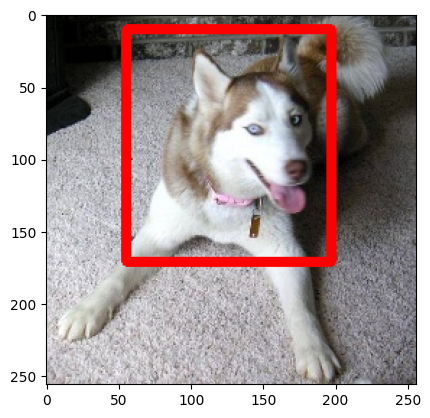

In [181]:
img = visualize_bbox(image, bbox)

print(img.shape)

plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


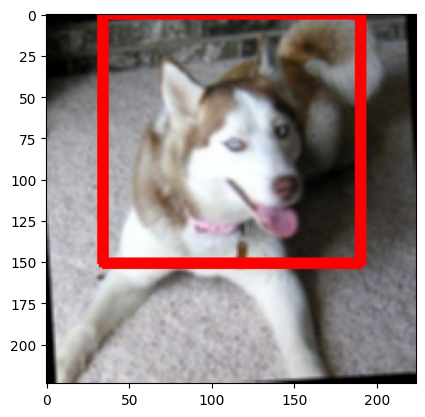

In [182]:
image_transformed =  visualize_bbox(image_transformed, bbox_transformed, transformed=True)

print(image_transformed.shape)

plt.imshow(image_transformed)



In [57]:
train_loader = DataLoader(dataset=train_transformed, batch_size=8, shuffle=True)
valid_loader = DataLoader(dataset=valid_transformed, batch_size=8, shuffle=True)

## Model

In [58]:
pre_trained_model = models.resnet50(pretrained=True)

e:\pytorch-course\torchenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\pytorch-course\torchenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
pre_trained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [60]:
for param in pre_trained_model.parameters():
    param.requires_grad = False

In [61]:
last_layer_in_features =  pre_trained_model.fc.in_features
last_layer_in_features

2048

In [62]:
pre_trained_model = nn.Sequential(*list(pre_trained_model.children())[:-1])
pre_trained_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [63]:
class LocalizationModel(nn.Module):
    
    def __init__(self, pre_trained_model, last_layer_in_features, out_features):
        super().__init__()
        self.pretrained_part = pre_trained_model
        self.class_out = nn.Linear(in_features=last_layer_in_features, out_features=out_features)
        self.bbox_out = nn.Linear(in_features=last_layer_in_features, out_features=4)

    def forward(self, x):
        x = self.pretrained_part(x)
        x = x.view(x.size()[0], -1)
        class_label = torch.sigmoid(self.class_out(x))

        bbox = self.bbox_out(x)

        return class_label, bbox

In [64]:
final_model = LocalizationModel(pre_trained_model, last_layer_in_features, 1)

In [65]:
final_model

LocalizationModel(
  (pretrained_part): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [66]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [67]:
final_model.to(device=device)

LocalizationModel(
  (pretrained_part): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

## Train

In [68]:
optimizer = optim.Adam(final_model.parameters(), lr=0.001)

In [69]:
classificatio_loss = nn.BCELoss()
bbox_loss = nn.MSELoss()

In [70]:
def train(train_loader, valid_loader, optimizer, class_loss, bbox_loss, epochs, model, device, data_length):
    valid_losses = []
    valid_accuracies = []

    for epoch in range(epochs):
        tot_loss = 0
        tot_correct = 0

        model.train()

        for (x, y, z) in train_loader:
            x = x.to(device)
            y = y.to(device)
            z = z.to(device)

            y_hat, z_hat = model(x)
            # print(z_hat)
            # print(z)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                class_l = class_loss(y_hat, y)
                bbox_l = bbox_loss(z_hat, z)
                (bbox_l + class_l).backward()
                optimizer.step()


        model.eval()

        for (x_val , y_val, z_val) in valid_loader:
        	
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            z_val =  z_val.to(device)
          
            y_val_hat,z_val_hat= model(x_val)
            # print(z_val_hat)
            # print(z_val)
                
            class_l_val = class_loss(y_val_hat, y_val)
            bbox_l_val = bbox_loss(z_val_hat, z_val)

            pred_labels = torch.tensor([1 if y_val_hat[l]>=0.5 else 0 for l in range(y_val_hat.shape[0])]).view(-1, 1).to(device)
           
            tot_correct += torch.sum(y_val == pred_labels)
            tot_loss += (class_l_val + bbox_l_val)
           
        
        print(f'epoch {epoch}: validation_loss: {tot_loss}')
        print(f'epoch {epoch}: validation_accuracy: {tot_correct / data_length}')

        valid_losses.append(tot_loss.item())
        valid_accuracies.append((tot_correct / data_length).item())

    
    
    print(f'all_epochs_acc: {valid_accuracies} \nall_epochs_loss: {valid_losses}')


In [71]:
data_length = len(train_transformed)

train(train_loader=train_loader,\
     valid_loader=valid_loader,\
         optimizer=optimizer,\
             class_loss=classificatio_loss,\
                 bbox_loss=bbox_loss, epochs=100,\
                     model=final_model, device=device,\
                        data_length=data_length)

epoch 0: validation_loss: 760271.125
epoch 0: validation_accuracy: 0.9775000214576721
epoch 1: validation_loss: 192610.0
epoch 1: validation_accuracy: 0.9800000190734863
epoch 2: validation_loss: 138269.296875
epoch 2: validation_accuracy: 0.9800000190734863
epoch 3: validation_loss: 129984.8984375
epoch 3: validation_accuracy: 0.9616667032241821
epoch 4: validation_loss: 129014.6953125
epoch 4: validation_accuracy: 0.9566667079925537
epoch 5: validation_loss: 128053.0703125
epoch 5: validation_accuracy: 0.98416668176651
epoch 6: validation_loss: 124444.3046875
epoch 6: validation_accuracy: 0.9858333468437195
epoch 7: validation_loss: 126896.6640625
epoch 7: validation_accuracy: 0.9708333611488342
epoch 8: validation_loss: 123275.0859375
epoch 8: validation_accuracy: 0.9858333468437195
epoch 9: validation_loss: 120585.5390625
epoch 9: validation_accuracy: 0.9750000238418579
epoch 10: validation_loss: 122435.28125
epoch 10: validation_accuracy: 0.9800000190734863
epoch 11: validation_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class: dog


(-0.5, 223.5, 223.5, -0.5)

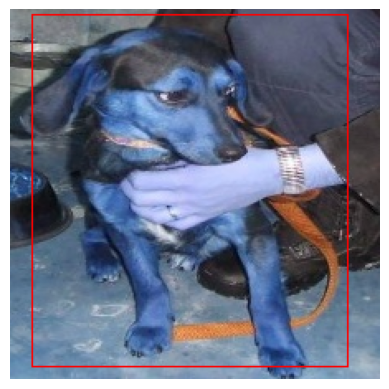

In [148]:
image = valid_transformed[659][0]
image = torch.reshape(image, (1, 3, 224, 224))
y_pred, bbox = final_model(image.to(device))
label = 'cat' if y_pred<=0.5 else 'dog'
print(f'class: {label}')

x1 = bbox[0][0] 
x2 = bbox[0][2] 
y1 = bbox[0][1] 
y2 = bbox[0][3] 

image = torch.reshape(image, (3, 224, 224))
image =image.permute(1, 2, 0)
image = np.asarray(image)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

cv2.rectangle(image, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0),1)
    
plt.imshow(image)
plt.axis('off')